#**The goal of this project is to build ARIMA-type model on the Champaign sales dataset**


**About the Dataset:**

The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France). The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data. The values are a count of millions of sales and there are 105 observations.

In [1]:
# Let's first import all the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pmdarima as pm

In [4]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import opendatasets as od

In [6]:
# Let's download the dataset
od.download('https://www.kaggle.com/datasets/piyushagni5/monthly-sales-of-french-champagne')

Skipping, found downloaded files in "./monthly-sales-of-french-champagne" (use force=True to force download)


In [7]:
file =('/content/monthly-sales-of-french-champagne/monthly_champagne_sales.csv')

In [8]:
# Let's create the data frame 
df=pd.read_csv(file,parse_dates=True,index_col='Month',skipfooter=2)

In [10]:
df.columns=['Sales']

In [11]:
# Let's set index frequency of the sales as monthly
df.index.freq='MS'

In [12]:
df.head(15)

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
1964-06-01,3036
1964-07-01,2282
1964-08-01,2212
1964-09-01,2922


In [13]:
# Let's check the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 1964-01-01 to 1972-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   103 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


**We see that the dataset has 103 entries of sales from 1964-01-01 to 1972-07-01. Non of them are null.**

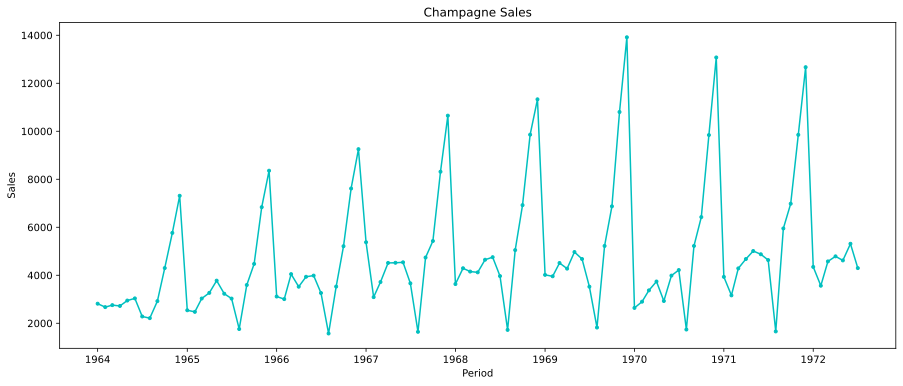

In [14]:
# let's look how the graph of Sales looks
plt.figure(figsize=(15,6))
plt.plot(df.index,df.Sales,color='c',marker='.')
plt.title('Champagne Sales')
plt.xlabel('Period')
plt.ylabel('Sales')
plt.show()

**We see that there is strong sesonality in the time series as well as an upward trend over the all period and it seems there is a moderate decline over the last 2 years**

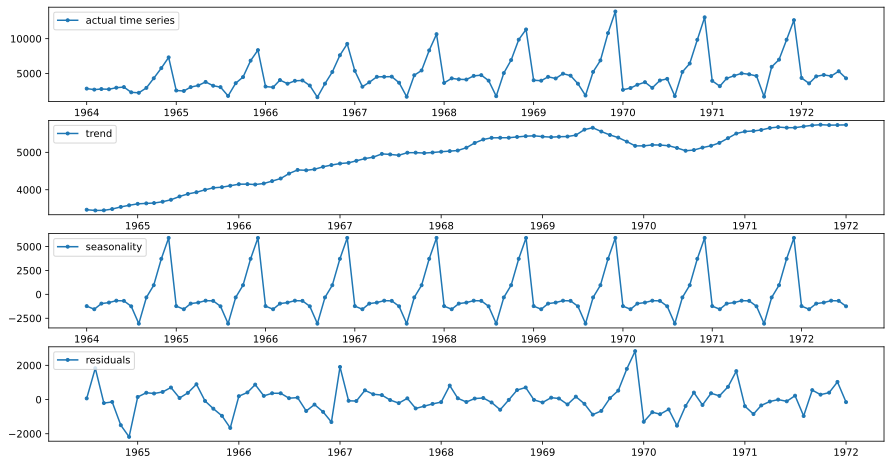

In [15]:
# Lets decompose it into trend, seasonality and residual
df_decomp=seasonal_decompose(df)
trend=df_decomp.trend
seasonality=df_decomp.seasonal
residuals=df_decomp.resid
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(df,marker='.',label='actual time series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,marker='.',label='trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonality,marker='.',label='seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuals,marker='.',label='residuals')
plt.legend(loc='upper left')
plt.show()

**We can see that there is indeed strong seasonality**

In [16]:
# Let's split the dataset into train and test, with test part being the last 20 
# entries
Ntest=20
train,test=df[:-Ntest], df[-Ntest:]
print(train)
print(test)

            Sales
Month            
1964-01-01   2815
1964-02-01   2672
1964-03-01   2755
1964-04-01   2721
1964-05-01   2946
...           ...
1970-07-01   4217
1970-08-01   1738
1970-09-01   5221
1970-10-01   6424
1970-11-01   9842

[83 rows x 1 columns]
            Sales
Month            
1970-12-01  13076
1971-01-01   3934
1971-02-01   3162
1971-03-01   4286
1971-04-01   4676
1971-05-01   5010
1971-06-01   4874
1971-07-01   4633
1971-08-01   1659
1971-09-01   5951
1971-10-01   6981
1971-11-01   9851
1971-12-01  12670
1972-01-01   4348
1972-02-01   3564
1972-03-01   4577
1972-04-01   4788
1972-05-01   4618
1972-06-01   5312
1972-07-01   4298


In [17]:
# Let's do the persistence (naive) forecast first
naive_predictions=np.concatenate([train.values[-1].flatten(),test.values[:-1].flatten()])

In [18]:
# Let's create a function to measure RMSE
def rmse(y,t):
  return np.mean(np.sqrt((y-t)**2))

In [19]:
# Now lets check rmse for the naive forecast (persistence)
rmse(naive_predictions,test['Sales'])

2078.3

In [20]:
# Lets check the accuracy
naive_accuracy=1-rmse(naive_predictions,test['Sales'])/np.mean(test['Sales'])
naive_accuracy

0.6297609292051163

In [21]:
# Let's build the function based on the  Augmented Dickey Fuller test 
# to check the stationarity of the data 
def adf_test(data):
  test_result=adfuller(data)
  pvalue=test_result[1]
  
  if pvalue>=0.05:
    print('the data is not stationary')
    print('pvalue is',pvalue)
  else:
    print('the data is stationary')
    print('pvalue is',pvalue)

In [22]:
adf_test(df['Sales'])

the data is not stationary
pvalue is 0.4153025444047691


In [23]:
# Let's do differencing to make the data more stationary
df_diff=df['Sales'].diff().dropna()

In [24]:
adfuller(df_diff)

(-26.70301933150486,
 0.0,
 10,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 1436.3336323099088)

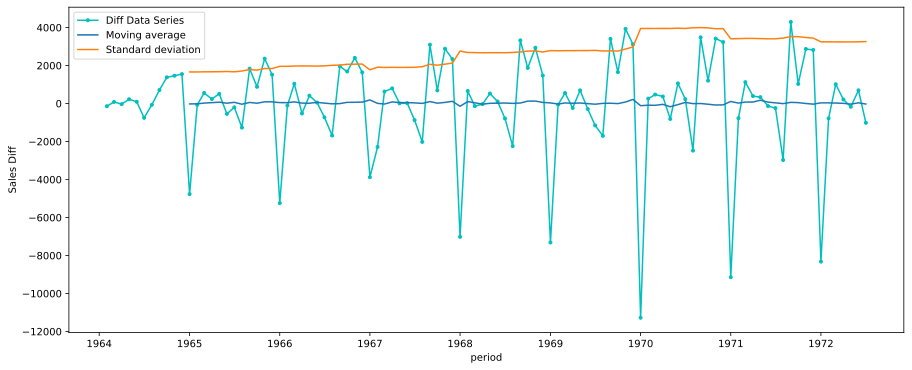

In [25]:
# Lets visualize the differenced data series
plt.figure(figsize=(15,6))
MA=df_diff.rolling(window=12).mean()
MStd=df_diff.rolling(window=12).std()
plt.plot(df_diff.index,df_diff.values,color='c',marker='.',label='Diff Data Series')
plt.plot(MA,label='Moving average')
plt.plot(MStd,label='Standard deviation')
plt.xlabel('period')
plt.ylabel('Sales Diff')
plt.legend()
plt.show()

**We can see that time series is indeed stationary after 1 differencing**

**We see that one differencing is enough, so we can proceed with the modeling**

<Figure size 1152x576 with 0 Axes>

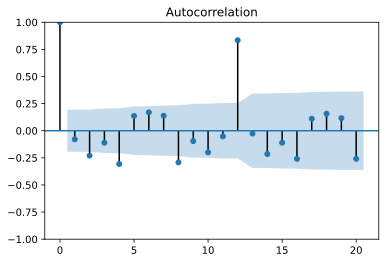

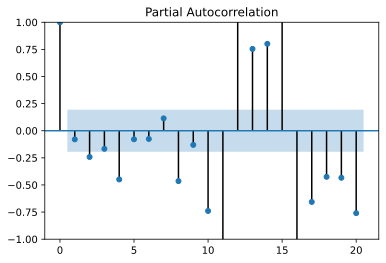

In [26]:
# Let's plot the ACF and PACF plots to catch an idea of the p and q orders
plt.figure(figsize = (16, 8))
plot_acf(df_diff, lags = 20) 
plot_pacf(df_diff, lags = 20)
plt.show()

**Looking at the graph probably we should start with p=4 and q=12**



In [27]:
# Lets build the ARIMA model with I=1 as we have defined by adf_test
# After trying several combinations of p and q, the values of 10 and 12 correspondingly seems to be optimal 
arima_model=ARIMA(train['Sales'],order=(10,1,12),freq='MS')
arima_result=arima_model.fit()

In [28]:
# Let's build the function which creates predictions and forecast for 
# 25 months based on train, test data and the fitted model and, plots the
# neccessary graphs
def plot_and_forecast(train,test,result,d,col='Sales'):
  # train, test are train and test data, result is the fitted model, 
  # d is the number of an entry from which the model will start predictions  
  fig,ax=plt.subplots(figsize=(15,5))
  ax.plot(train[col],label='Train Sales')
  train_pred=result.predict(start=train.index[d],end=train.index[-1]) 
  ax.plot(train.index[d:],train_pred,label='fitted')
  ax.plot(test[col],label='Test Sales')
  test_prediction=result.get_forecast(Ntest)
  conf_int=test_prediction.conf_int()
  lower,upper=conf_int[f'lower {col}'],conf_int[f'upper {col}']
  test_forecast=test_prediction.predicted_mean
  ax.plot(test_forecast,label='Test Forecast')
  forecast_period=pd.date_range('1972-08-01',periods=25,freq='M')
  future_prediction=result.get_prediction(start=forecast_period[0],\
                                          end=forecast_period[-1])
  future_forecast=future_prediction.predicted_mean
  ax.plot(future_forecast,label='Future Forecast')
  ax.fill_between(test.index, \
                  lower,upper, \
                  color='red',alpha=0.2)
  ax.legend()
  return test_forecast,future_forecast,lower,upper

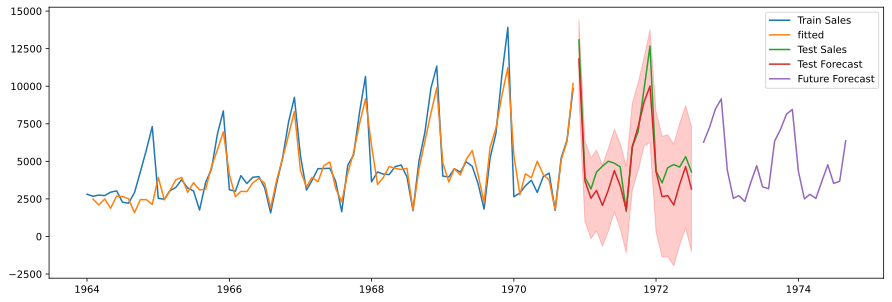

In [29]:
test_forecast_arima_10_1_12,future_forecast_arima_10_1_12,lower_arima_10_1_12, \
upper_arima_10_1_12=plot_and_forecast(train,test,arima_result,1)

In [30]:
# Let's check what is RMSE for the test predictions is
rmse_arima_10_1_12=rmse(test_forecast_arima_10_1_12,test['Sales'])
rmse_arima_10_1_12

1105.2595712500965

In [31]:
# Lets check the accuracy
accuracy_arima_10_1_12=1-rmse(test_forecast_arima_10_1_12,test['Sales'])/np.mean(test['Sales'])
accuracy_arima_10_1_12

0.8031033649392353

In [32]:
# Let's try auto arima model 
auto_arima=pm.auto_arima(train['Sales'],seasonal=True,m=12,max_P=15,max_D=3,max_Q=15)

In [33]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   83
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -567.749
Date:                             Sat, 17 Sep 2022   AIC                           1139.498
Time:                                     13:54:14   BIC                           1143.995
Sample:                                 01-01-1964   HQIC                          1141.284
                                      - 11-01-1970                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8832      0.059    -15.019      0.000      -0.998      -0.768
sigma2      5.895e+05   7.23e+04      8.152      0.000    4.48e+05    7.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 6.60
Prob(Q):                              0.70   Prob(JB):                         0.04
Heteroskedasticity (H):               3.01   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**We see that the optimal model found by the auto_arima is SARIMAX(0, 1, 1)x(0, 1, [], 12)**

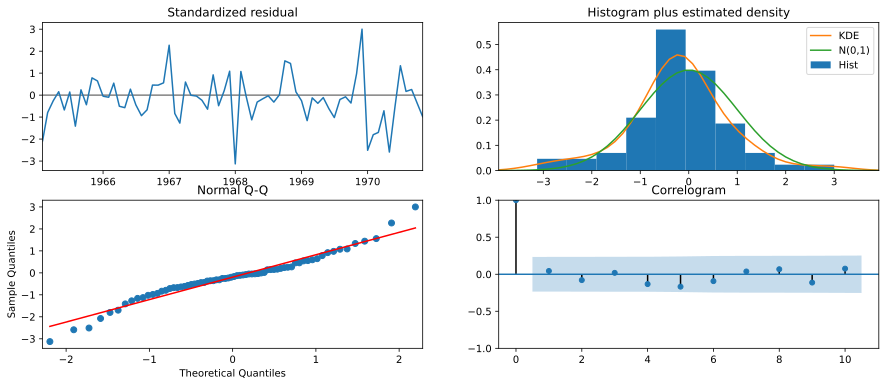

In [34]:
# Let's see the diagnostic for the found auto arima model
fig=plt.figure(figsize=(15,6))
fig=auto_arima.plot_diagnostics(fig=fig)

**We can see that:**
1. Mean is randomly fluctuating around zero (Standardized residual plot)
2. The resiaduals distribution is very close to the standard normal distribution (Histogram plus estimated density plot)
3. All of the dots are fall closely to the line at Normal Q-Q plot. So distribution of residuals is not skewed. 
4. ACF plot (Correlogram) shows that there is no significant lag except 0. So the residuals are not autocorrelated, which means that there is no pattern in residuals that is not explained by the model. 

In [35]:
fitted_auto_arima=auto_arima.predict_in_sample(start=1,end=len(train))
test_pred_auto_arima,confint_auto_arima=auto_arima.predict(n_periods=Ntest,return_conf_int=True)
future_forecast_autoarima=auto_arima.predict(n_periods=24)

In [36]:
lower_auto_arima,upper_auto_arima=confint_auto_arima[:,0],confint_auto_arima[:,1]

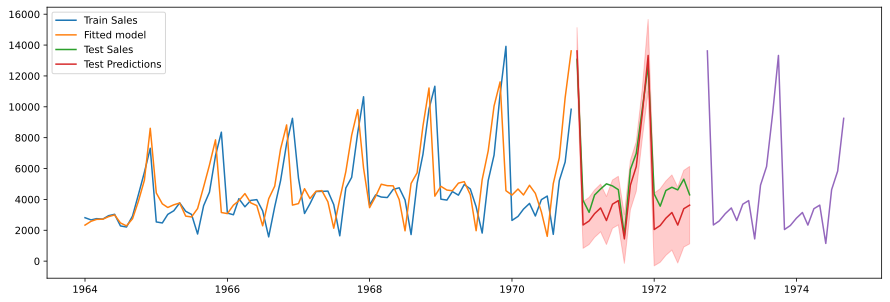

In [37]:
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(train['Sales'],label='Train Sales')
ax.plot(train.index,fitted_auto_arima,label='Fitted model')
ax.plot(test.index,test['Sales'],label='Test Sales')
ax.plot(test.index,test_pred_auto_arima,label='Test Predictions')
forecast_periods=pd.date_range('1972-09-30',periods=24,freq='M')
ax.plot(forecast_periods,future_forecast_autoarima)
ax.fill_between(test.index, \
                lower_auto_arima,upper_auto_arima, \
                color='red',alpha=0.2)
ax.legend();

In [38]:
# Let's check what is RMSE for the test predictions is
rmse_auto_arima=rmse(test_pred_auto_arima,test['Sales'])
rmse_auto_arima

1215.084606239021

In [45]:
# Lets check the accuracy
accuracy_auto_arima=1-rmse(test_pred_auto_arima,test['Sales'])/np.mean(test['Sales'])
accuracy_auto_arima

0.7835385673141018

**We see that accuracy of auto arima is slightly lower than ARIMA(10,1,12): 78.4% vs 80.3%. But the confidence interval is a lot tighter for the auto arima. Let's check the aic for the each model.** 

In [40]:
arima_result.aic

1438.162738708823

In [41]:
auto_arima.aic()

1139.4978906390343

**From the Akaike information criterion (AIC) we see that auto_arima fits the data a lot better, so we go with this model.**

In [42]:
# Let's create the Data Frame for the forecast
df_forecast=pd.DataFrame(future_forecast_autoarima,columns=['Sales forecast'])

In [43]:
df_forecast

,Sales forecast
1970-12-01,13621.695813
1971-01-01,2344.695813
1971-02-01,2604.695813
1971-03-01,3075.695813
1971-04-01,3445.695813
1971-05-01,2632.695813
1971-06-01,3691.695813
1971-07-01,3922.695813
1971-08-01,1443.695813
1971-09-01,4926.695813
